# Induced earthquake statistics in geothermal context

Review of the underground seismic response to past underground stimulation projects aimed at creating, or enhancing, a geothermal reservoir. Induced earthquake hazard is characterised by the overall seismic activity $a_{fb}$ that is normalised by the injected fluid volume $V$ and the parameter $b$ of the Gutenberg-Richter law. See Mignan et al. (2021) for more details.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression

## Literature review

Parameters obtained from the literature:

`ID`: stimulation identifier, `site`: site name, `V_m3`: total injected fluid volume in m$^3$, `dV_LperSec`: mean injection rate in L/s, `N_above_m0`: number of earthquakes above $m_0$, `m0`: minimum magnitude, `mmax`: maximum observed magnitude, `afb`: $a$-value of the Gutenberg-Richter law normalised by $V$ (underground feedback), `b`: $b$-value of the Gutenberg-Richter law, `category`: data quality level for data mining, `comment_N`: if $N$ for stimulation phase only, or including post-injection, `commnet_m0`: minimum observed magnitude or completeness magnitude $m_c$.

In [2]:
data = pd.read_csv('data_geothermal_undergroundfeedback_v1.csv')
n = len(data)
data

,ID,site,V_m3,dV_LperSec,N_above_m0,m0,mmax,afb,b,category,comment_N,comment_m0
0,77ta,Torre Alfina,4200.0,NaN,177.0,NaN,3.00,NaN,NaN,D,NaN,NaN
1,78ce,Cesano,2000.0,NaN,NaN,NaN,2.00,NaN,NaN,D,NaN,NaN
2,83fh,Fenton Hill,21000.0,100.00,850.0,-3.0,0.00,NaN,NaN,C,NaN,NaN
3,87lm,Le Mayet,42800.0,14.00,107.0,-2.0,-1.00,NaN,NaN,C,NaN,NaN
4,88hi,Hijiori,2000.0,100.00,65.0,-4.0,-1.00,NaN,NaN,C,NaN,NaN
5,89fj,Fjallbacka,200.0,NaN,NaN,NaN,-0.20,NaN,NaN,D,NaN,NaN
6,91og,Ogashi,10100.0,11.00,1504.0,-2.0,NaN,-2.65,0.74,A,injection period only,mc
7,92hi,Hijiori,2100.0,NaN,90.0,-4.0,0.00,NaN,NaN,C,NaN,NaN
8,93og,Ogashi,5400.0,15.00,762.0,-1.2,NaN,-3.20,0.81,A,injection period only,mc
9,93sf,Soultz-sous-Forets,25900.0,19.00,9550.0,-1.0,1.90,-2.00,1.38,A,injection period only,mc


## Data mining

The critical parameter $a_{fb}$ for induced earthquake hazard assessment is rarely given in the literature (category A). It can however be derived from other parameters since we have
$$ a_{fb} = \log_{10} N(\ge m_0) + b m_0 -\log_{10} V $$
The result is straightforward when $V$, $N$, $m_0$ and $b$ are also available (category B). When $b$ is missing, we proceed with mean imputation (category C). Finally when we have only one anchor point in the Gutenberg-Richter law (one extreme event of magnitude $m = m_{max}$) (category D), we consider $N(\ge m_0) = 1$ with $m_0 \le m_{max}$ and $m_0 = f(m_{max})$ a linear regression fitted to observations from categories A-C.

In [3]:
## DATA CATEGORIES ##
#A: afb, b available
#B: V, N, m0, mmax, b available
#C: V, N, m0, mmax available
#D: V, mmax available

indA = data['category'] == 'A'
indB = data['category'] == 'B'
indC = data['category'] == 'C'
indD = data['category'] == 'D'

print('percentage in category A:', np.round(np.sum(indA)/n*100), '%')
print('percentage in category B:', np.round(np.sum(indB)/n*100), '%')
print('percentage in category C:', np.round(np.sum(indC)/n*100), '%')
print('percentage in category D:', np.round(np.sum(indD)/n*100), '%')

percentage in category A: 36.0 %
percentage in category B: 28.0 %
percentage in category C: 26.0 %
percentage in category D: 10.0 %


In [4]:
## MEAN IMPUTATION ##
bval_mean = np.round(np.nanmean(data['b']), decimals = 2)
data['b_nogap'] = data['b']
data.loc[data['b'].isna(), 'b_nogap'] = bval_mean

Model slope:     0.6243697645008012
Model intercept: -2.1542474888673824


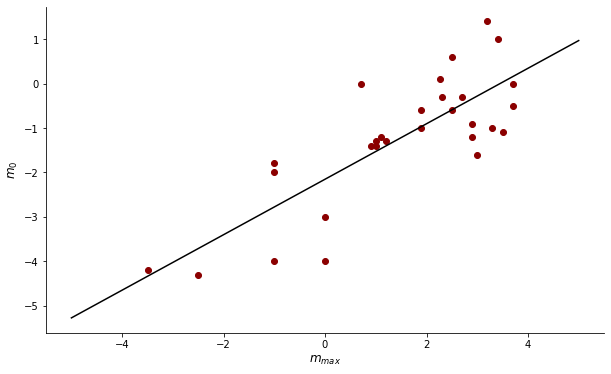

In [5]:
## m_0 derived from m_max ##
indnona = np.logical_and(data['m0'].notna(), data['mmax'].notna())
x = data[indnona]['mmax'].values
y = data[indnona]['m0'].values

model = LinearRegression(fit_intercept = True)
model.fit(x[:, np.newaxis], y)

xfit = np.linspace(-5,5,100)
yfit = model.predict(xfit[:, np.newaxis])

fig, axs = plt.subplots(1,1, figsize = (10,6))
plt.scatter(x, y, color = 'darkred')
plt.plot(xfit, yfit, 'black')
plt.xlabel('$m_{max}$', size = 12);
plt.ylabel('$m_0$', size = 12)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)

print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

In [6]:
m0_stat = model.coef_[0]*data.loc[data['category'] == 'D', 'mmax'] + model.intercept_

data['N_nogap'] = data['N_above_m0']
data['m0_nogap'] = data['m0']
data.loc[data['category'] == 'D', 'N_nogap'] = 1
data.loc[data['category'] == 'D', 'm0_nogap'] = m0_stat

In [7]:
## GET a_fb ##
indBCD = (data['category'] == 'B') | (data['category'] == 'C') | (data['category'] == 'D')
data_BCD = data[indBCD]

a_fb_BCD = np.log10(data_BCD['N_nogap']) + data_BCD['b_nogap'] * data_BCD['m0_nogap'] - np.log10(data_BCD['V_m3'])
a_fb_A = data[data['category'] == 'A']['afb']

a_fb_all = pd.concat([a_fb_A , a_fb_BCD])
data['afb_all'] = a_fb_all   # ordered automatically by original pandas loc

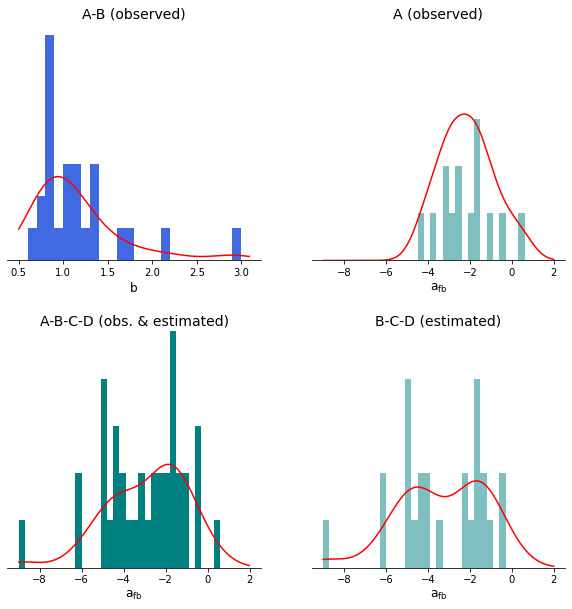

In [8]:
b = data['b'].dropna()

density_b = gaussian_kde(b)
density_b.covariance_factor = lambda : .5    #bandwidth
density_b._compute_covariance()
density_afb = gaussian_kde(a_fb_all)
density_afb.covariance_factor = lambda : .5    #bandwidth
density_afb._compute_covariance()
density_afb_A = gaussian_kde(a_fb_A)
density_afb_A.covariance_factor = lambda : .5    #bandwidth
density_afb_A._compute_covariance()
density_afb_BCD = gaussian_kde(a_fb_BCD)
density_afb_BCD.covariance_factor = lambda : .5    #bandwidth
density_afb_BCD._compute_covariance()
bi = np.arange(0.5,3.1,.01)
xi = np.arange(-9,2,.01)
normb = len(np.arange(0.5, 3.1, .1))*.1
norma = len(np.arange(-9, 2, .3))*.3

fig, axs = plt.subplots(2,2, figsize = (10,10))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.subplots_adjust(hspace = .3)

axs[0,0].hist(data['b'], bins = np.arange(0.5, 3.1, .1), color = 'royalblue')
axs[0,0].plot(bi, density_b(bi)*normb, 'r')
axs[0,0].set_xlabel('b', size = 12)
axs[0,0].set_title('A-B (observed)', size = 14)
axs[0,0].spines['left'].set_visible(False)
axs[0,0].spines['right'].set_visible(False)
axs[0,0].spines['top'].set_visible(False)
axs[0,0].tick_params(left = False, labelleft=False)

axs[1,0].hist(a_fb_all, bins = np.arange(-9, 2, .3), color = 'teal')
axs[1,0].plot(xi, density_afb(xi)*norma, 'r')
axs[1,0].set_xlabel('$a_{fb}$', size = 12)
axs[1,0].set_ylim(0, 5)
axs[1,0].set_title('A-B-C-D (obs. & estimated)', size = 14)
axs[1,0].spines['left'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)
axs[1,0].spines['top'].set_visible(False)
axs[1,0].tick_params(left = False, labelleft=False)

axs[0,1].hist(a_fb_A, bins = np.arange(-9, 2, .3), color = 'teal', alpha =.5)
axs[0,1].plot(xi, density_afb_A(xi)*norma, 'r')
axs[0,1].set_xlabel('$a_{fb}$', size = 12)
axs[0,1].set_ylim(0, 5)
axs[0,1].set_title('A (observed)', size = 14)
axs[0,1].spines['left'].set_visible(False)
axs[0,1].spines['right'].set_visible(False)
axs[0,1].spines['top'].set_visible(False)
axs[0,1].tick_params(left = False, labelleft=False)

axs[1,1].hist(a_fb_BCD, bins = np.arange(-9, 2, .3), color = 'teal', alpha =.5);
axs[1,1].plot(xi, density_afb_BCD(xi)*norma, 'r')
axs[1,1].set_xlabel('$a_{fb}$', size = 12)
axs[1,1].set_ylim(0, 5)
axs[1,1].set_title('B-C-D (estimated)', size = 14)
axs[1,1].spines['left'].set_visible(False)
axs[1,1].spines['right'].set_visible(False)
axs[1,1].spines['top'].set_visible(False)
axs[1,1].tick_params(left = False, labelleft=False);

The data retrieved from the literature are at times ambiguous. Is $N$ given for the injection phase (required in the previous equation) or for both injection and post-injection phases (requiring correction)? Is $m_0$ the completeness magnitude $m_c$ (required in the previous equation) or the minimum observed magnitude $m_{min}$ (requiring correction)? Read Mignan et al. (2021) for details about the correction methods applied below.

In [9]:
## CORRECTING FOR m_0 = m_min (for plot) ##
k = 3
indm0_ambig = (data['comment_m0'].isna()) & (data['category'] != 'D') & (data['ID'] != '15as')
Nc = data[indm0_ambig]['N_above_m0'] / (data[indm0_ambig]['b_nogap']/(k-data[indm0_ambig]['b_nogap']) + 1)
mc = data[indm0_ambig]['m0'] + 1/(k-data[indm0_ambig]['b_nogap']) * \
    np.log10(data[indm0_ambig]['N_above_m0']*data[indm0_ambig]['b_nogap']* \
             (k-data[indm0_ambig]['b_nogap'])*np.log(10)/k)
a_fb_corr1 = np.log10(Nc) + data[indm0_ambig]['b_nogap']*mc - np.log10(data[indm0_ambig]['V_m3'])
a_fb_check1 = a_fb_all[indm0_ambig]

In [10]:
## CORRECTING FOR N = N_inj+N_post (for plot) ##
tau = 1
indpost_ambig = (data['comment_N'].isna()) & (data['category'] != 'D') & (data['dV_LperSec'].notna())
a_fb_corr2 = np.log10(data[indpost_ambig]['N_above_m0']) + data[indpost_ambig]['b_nogap']*\
    data[indpost_ambig]['m0']-np.log10(data[indpost_ambig]['V_m3'] + \
                                               tau*data[indpost_ambig]['dV_LperSec']*3600*24*1e-3)
a_fb_check2 = a_fb_all[indpost_ambig]

In [11]:
# select data rows where both corrections or only one of the 2 corrections (for table update)
indboth_ambig = (data['comment_N'].isna()) & (data['category'] != 'D') & (data['dV_LperSec'].notna()) \
    & (data['comment_m0'].isna()) & (data['ID'] != '15as')
indpostonly_ambig = (data['comment_N'].isna()) & (data['category'] != 'D') & (data['dV_LperSec'].notna()) \
    & ((data['comment_m0'].notna() | (data['ID'] == '15as')))
indm0only_ambig = (data['comment_m0'].isna()) & (data['category'] != 'D') & (data['ID'] != '15as') \
    & (data['comment_N'].notna())

In [12]:
## CORRECTING FOR N = N_inj+N_post & m_0 = m_min (for table) ##
Nc = data[indboth_ambig]['N_above_m0'] / (data[indboth_ambig]['b_nogap']/(k-data[indboth_ambig]['b_nogap']) + 1)
mc = data[indboth_ambig]['m0'] + 1/(k-data[indboth_ambig]['b_nogap']) * \
    np.log10(data[indboth_ambig]['N_above_m0']*data[indboth_ambig]['b_nogap']*(k-data[indboth_ambig]['b_nogap'])*\
             np.log(10)/k)
a_fb_corr3 = np.log10(Nc) + data[indboth_ambig]['b_nogap']*mc - np.log10(data[indboth_ambig]['V_m3']+ \
                                               tau*data[indboth_ambig]['dV_LperSec']*3600*24*1e-3)

## CORRECTING FOR N = N_inj+N_post (for table) ##
a_fb_corr4 = np.log10(data[indpostonly_ambig]['N_above_m0']) + data[indpostonly_ambig]['b_nogap']*\
    data[indpostonly_ambig]['m0']-np.log10(data[indpostonly_ambig]['V_m3'] + \
                                               tau*data[indpostonly_ambig]['dV_LperSec']*3600*24*1e-3)

## CORRECTING FOR m_0 = m_min (for table) ##
Nc = data[indm0only_ambig]['N_above_m0'] / (data[indm0only_ambig]['b_nogap']/(k-data[indm0only_ambig]['b_nogap']) + 1)
mc = data[indm0only_ambig]['m0'] + 1/(k-data[indm0only_ambig]['b_nogap']) * \
    np.log10(data[indm0only_ambig]['N_above_m0']*data[indm0only_ambig]['b_nogap']*\
             (k-data[indm0only_ambig]['b_nogap'])*np.log(10)/k)
a_fb_corr5 = np.log10(Nc) + data[indm0only_ambig]['b_nogap']*mc - np.log10(data[indm0only_ambig]['V_m3']+ \
                                               tau*data[indm0only_ambig]['dV_LperSec']*3600*24*1e-3)


tmp = np.logical_or(indboth_ambig, indpostonly_ambig)
indrest = ~np.logical_or(tmp, indm0only_ambig)

a_fb_corr = pd.concat([a_fb_all[indrest], a_fb_corr3, a_fb_corr4, a_fb_corr5])
data['afb_corr'] = a_fb_corr     # ordered automatically by original pandas loc

In [13]:
# checking a_fb correction method selection
np.c_[indboth_ambig, indm0only_ambig, ~np.logical_or(indboth_ambig, indm0only_ambig)]

array([[False, False,  True],
       [False, False,  True],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [ True, False, False],
       [False, False,  True],
       [False, False,  True],
       [ True, False, False],
       [False, False,  True],
       [ True, False, False],
       [False, False,  True],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [False, False,  True],
       [ True, False, False],
       [ True, False, False],
       [False,  True, False],
       [ True, False, False],
       [False,  True, False],
       [False, False,  True],
       [ True, False, False],
       [False,  True, False],
       [Fa

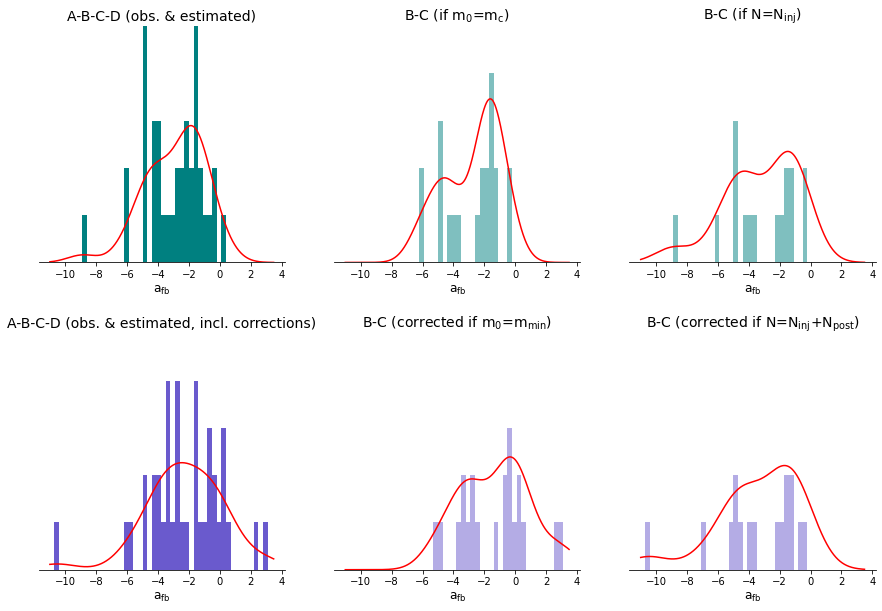

In [14]:
density_afb_corr1 = gaussian_kde(a_fb_corr1)
density_afb_corr1.covariance_factor = lambda : .5    #bandwidth
density_afb_corr1._compute_covariance()
density_afb_check1 = gaussian_kde(a_fb_check1)
density_afb_check1.covariance_factor = lambda : .5    #bandwidth
density_afb_check1._compute_covariance()
density_afb_corr2 = gaussian_kde(a_fb_corr2)
density_afb_corr2.covariance_factor = lambda : .5    #bandwidth
density_afb_corr2._compute_covariance()
density_afb_check2 = gaussian_kde(a_fb_check2)
density_afb_check2.covariance_factor = lambda : .5    #bandwidth
density_afb_check2._compute_covariance()
density_afb_final = gaussian_kde(a_fb_corr)
density_afb_final.covariance_factor = lambda : .5    #bandwidth
density_afb_final._compute_covariance()
xi = np.arange(-11,3.5,.01)
norma = len(np.arange(-11, 3.5, .3))*.3

fig, axs = plt.subplots(2,3, figsize = (15,10))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.subplots_adjust(hspace = .3)

axs[0,0].hist(a_fb_all, bins = np.arange(-11, 3.5, .3), color = 'teal')
axs[0,0].plot(xi, density_afb(xi)*norma, 'r')
axs[0,0].set_xlabel('$a_{fb}$', size = 12)
axs[0,0].set_ylim(0, 5)
axs[0,0].set_title('A-B-C-D (obs. & estimated)', size = 14)
axs[0,0].spines['left'].set_visible(False)
axs[0,0].spines['right'].set_visible(False)
axs[0,0].spines['top'].set_visible(False)
axs[0,0].tick_params(left = False, labelleft=False)

axs[1,0].hist(a_fb_corr, bins = np.arange(-11, 3.5, .3), color = 'slateblue')
axs[1,0].plot(xi, density_afb_final(xi)*norma, 'r')
axs[1,0].set_xlabel('$a_{fb}$', size = 12)
axs[1,0].set_ylim(0, 5)
axs[1,0].set_title('A-B-C-D (obs. & estimated, incl. corrections)', size = 14)
axs[1,0].spines['left'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)
axs[1,0].spines['top'].set_visible(False)
axs[1,0].tick_params(left = False, labelleft=False)

axs[0,1].hist(a_fb_check1, bins = np.arange(-11, 3.5, .3), color = 'teal', alpha = .5)
axs[0,1].plot(xi, density_afb_check1(xi)*norma, 'r')
axs[0,1].set_xlabel('$a_{fb}$', size = 12)
axs[0,1].set_ylim(0, 5)
axs[0,1].set_title('B-C (if $m_0$=$m_{c}$)', size = 14)
axs[0,1].spines['left'].set_visible(False)
axs[0,1].spines['right'].set_visible(False)
axs[0,1].spines['top'].set_visible(False)
axs[0,1].tick_params(left = False, labelleft=False)

axs[1,1].hist(a_fb_corr1, bins = np.arange(-11, 3.5, .3), color = 'slateblue', alpha = .5)
axs[1,1].plot(xi, density_afb_corr1(xi)*norma, 'r')
axs[1,1].set_xlabel('$a_{fb}$', size = 12)
axs[1,1].set_ylim(0, 5)
axs[1,1].set_title('B-C (corrected if $m_0$=$m_{min}$)', size = 14)
axs[1,1].spines['left'].set_visible(False)
axs[1,1].spines['right'].set_visible(False)
axs[1,1].spines['top'].set_visible(False)
axs[1,1].tick_params(left = False, labelleft=False)

axs[0,2].hist(a_fb_check2, bins = np.arange(-11, 3.5, .3), color = 'teal', alpha = .5)
axs[0,2].plot(xi, density_afb_check2(xi)*norma, 'r')
axs[0,2].set_xlabel('$a_{fb}$', size = 12)
axs[0,2].set_ylim(0, 5)
axs[0,2].set_title('B-C (if N=$N_{inj}$)', size = 14)
axs[0,2].spines['left'].set_visible(False)
axs[0,2].spines['right'].set_visible(False)
axs[0,2].spines['top'].set_visible(False)
axs[0,2].tick_params(left = False, labelleft=False)

axs[1,2].hist(a_fb_corr2, bins = np.arange(-11, 3.5, .3), color = 'slateblue', alpha = .5)
axs[1,2].plot(xi, density_afb_corr2(xi)*norma, 'r')
axs[1,2].set_xlabel('$a_{fb}$', size = 12)
axs[1,2].set_ylim(0, 5)
axs[1,2].set_title('B-C (corrected if N=$N_{inj}$+$N_{post}$)', size = 14)
axs[1,2].spines['left'].set_visible(False)
axs[1,2].spines['right'].set_visible(False)
axs[1,2].spines['top'].set_visible(False)
axs[1,2].tick_params(left = False, labelleft=False)

In [15]:
## SAVE FILLED TABLE ##
data.to_csv('data_geothermal_undergroundfeedback_v1_dataminingresult.csv', index=False) 